### Object Classification


#### Load Data

In [1]:
# LOAD FILES FOR CIFAR-10 IMAGE DATA
# Import Modules
import pickle
import os
import pickle
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import find_peaks_cwt
import random
from sklearn.utils import shuffle
import csv
%matplotlib inline
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile
import glob

# Change Directory
os.chdir('..')
os.chdir('Data/')
OS=str(os.getcwd())

In [3]:
# LOAD FILES FOR CIFAR-10 IMAGE DATA
# Load Label Names
LabelNames=['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck']

# Load Folder Path
DatasetFolderPath='Cifar-10-Batches-Py'

# Specify Number of Batches
NumBatches=5

# Initiate Training Data
XTrain,YTrain=[],[]

# Load Batch Data in Loops    
for BatchID in range(1,NumBatches+1):
    with open(DatasetFolderPath+'/data_batch_'+str(BatchID),mode='rb') as File:
        Batch=pickle.load(File,encoding='latin1')
    if (BatchID==1):
        XTrain=Batch['data'].reshape((len(Batch['data']),3,32,32)).transpose(0, 2, 3, 1)
        YTrain=Batch['labels']
    else:
        XTrainTemp,YTrainTemp=[],[]
        XTrainTemp=Batch['data'].reshape((len(Batch['data']),3,32,32)).transpose(0, 2, 3, 1)
        YTrainTemp=Batch['labels']
        XTrain=np.concatenate((XTrain,XTrainTemp),axis=0)
        YTrain=np.concatenate((YTrain,YTrainTemp),axis=0)

# Assert to Ensure Equal Size of Input & Output Data
assert(len(XTrain)==len(YTrain))

# Number of Unique Classes and Labels
NumClass=len(set(YTrain))

# Print Data Characteristics
print("Training Set:{} Samples".format(len(XTrain)))
print("Image Shape:{}".format(XTrain[0].shape))
print('Number of Classes: {}'.format(dict(zip(*np.unique(YTrain,return_counts=True)))))
print('First 20 Labels: {}'.format(YTrain[:20]))

Training Set:50000 Samples
Image Shape:(32, 32, 3)
Number of Classes: {0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}
First 20 Labels: [6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6]


Example of Image 46681:
Min Value: 13 Max Value: 232
Label ID: 2 Name: Bird


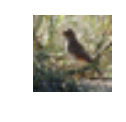

In [5]:
# LOAD FILES FOR CIFAR-10 IMAGE DATA
# Plot Random Image
Index=Index=random.randint(0,len(XTrain))
SampleImage=XTrain[Index]
SampleLabel=YTrain[Index]
print('Example of Image {}:'.format(Index))
print('Min Value: {} Max Value: {}'.format(SampleImage.min(),SampleImage.max()))
print('Label ID: {} Name: {}'.format(SampleLabel,LabelNames[SampleLabel]))
plt.figure(figsize=(1,1))
plt.axis('off')
plt.imshow(SampleImage)

Example of Image 7274:
Min Value: 12 Max Value: 228
Label ID: 4 Name: Deer


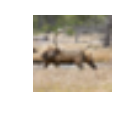

In [6]:
# LOAD FILES FOR CIFAR-10 IMAGE DATA
# Load Test Data
with open(DatasetFolderPath+'/test_batch',mode='rb') as File:
    Batch=pickle.load(File, encoding='latin1')
# load the training data
XTest=Batch['data'].reshape((len(Batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
YTest=Batch['labels']

# Plot Random Image
Index=Index=random.randint(0,len(XTest))
SampleImage=XTrain[Index]
SampleLabel=YTrain[Index]
print('Example of Image {}:'.format(Index))
print('Min Value: {} Max Value: {}'.format(SampleImage.min(),SampleImage.max()))
print('Label ID: {} Name: {}'.format(SampleLabel,LabelNames[SampleLabel]))
plt.figure(figsize=(1,1))
plt.axis('off')
plt.imshow(SampleImage)

#### Data Exploration

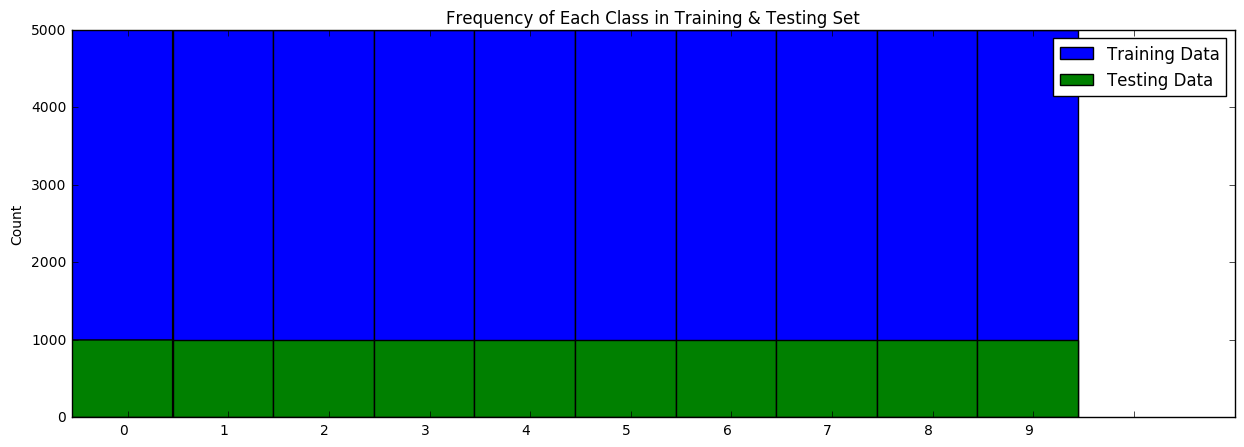

In [7]:
# DATA EXPLORATION 
# Plot the Histograms for Training and Testing Data
plt.figure(figsize=(15,5))
plt.hist(YTrain,bins=10,label='Training Data',color='blue')
plt.hist(YTest,bins=10,label='Testing Data',color='green')
plt.title('Frequency of Each Class in Training & Testing Set')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.xticks(np.arange(0.5,10+0.5,0.9),[0,1,2,3,4,5,6,7,8,9],ha='right',rotation=0)
plt.show()

#### Data Preprocessing

In [8]:
# DATA PREPROCESSING
# Shuffle the Data
XTrain,YTrain=shuffle(XTrain,YTrain)
XTest,YTest=shuffle(XTest,YTest)
print('Training and Testing Data Shuffled')

Training and Testing Data Shuffled


In [9]:
# DATA PREPROCESSING
# Add Validation Data
from sklearn.cross_validation import train_test_split
XTrain,XVal,YTrain,YVal=train_test_split(XTrain,YTrain,test_size=0.10,random_state=0)
print('Training Data Randomized and Split for Validation')
print('Training Data Size:'+str(XTrain.shape))
print('Validation Data Size:'+str(XVal.shape))

Training Data Randomized and Split for Validation
Training Data Size:(45000, 32, 32, 3)
Validation Data Size:(5000, 32, 32, 3)


#### Model Architecture

In [10]:
# DEFINE ARCHITECTURE
# Import Tensorflow
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import time

In [21]:
# DEFINE ARCHITECTURE
# Set Epochs and Batch Size
Epochs=20
BatchSize=128

In [12]:
# DEFINE ARCHITECTURE
# Load Pre-Trained Network
NetData=np.load("bvlc-alexnet.npy",encoding="latin1").item()
print('Pre-trained Network Loaded!')

Pre-trained Network Loaded!


In [14]:
# DEFINE ARCHITECTURE
# Set a Placeholder
Features=tf.placeholder(tf.float32,(None,32,32,3))
Labels=tf.placeholder(tf.int64,None)
Resized=tf.image.resize_images(Features,(227,227))
print('Set Placeholder!')

Set Placeholder!


In [16]:
# DEFINE ALEXNET ARCHITECTURE
def AlexNetCIFAR10(X):
    # Layer 01: Convolutional.
    # Set Layer Parameters & Network
    W1=tf.Variable(NetData["conv1"][0])
    B1=tf.Variable(NetData["conv1"][1])
    CO=96
    CI=X.get_shape()[-1]
    assert CI%1==0
    assert CO%1==0
    Conv1Init=tf.nn.conv2d(X,W1,[1,4,4,1],padding='SAME')
    Conv1=tf.reshape(tf.nn.bias_add(Conv1Init,B1),[-1]+Conv1Init.get_shape().as_list()[1:])
    
    # Set Activation
    Conv1=tf.nn.relu(Conv1)
    
    # Do Normalization
    Lrn1=tf.nn.local_response_normalization(Conv1,depth_radius=2,alpha=2e-05,beta=0.75,bias=1.0)
    
    # Do Pooling
    Maxpool1=tf.nn.max_pool(Lrn1,ksize=[1,3,3,1],strides=[1,2,2,1],padding='VALID')
    
    # Layer 02: Convolutional.
    # Set Layer Parameters & Network
    W2=tf.Variable(NetData["conv2"][0])
    B2=tf.Variable(NetData["conv2"][1])
    InputGroups=tf.split(Maxpool1,2,3)
    KernelGroups=tf.split(W2,2,3)
    Convolve=lambda i,k:tf.nn.conv2d(i,k,[1,1,1,1],padding='SAME')
    OutputGroups=[Convolve(i,k) for i,k in zip(InputGroups,KernelGroups)]
    Conv2=tf.concat(OutputGroups,3)
    Conv2=tf.reshape(tf.nn.bias_add(Conv2,B2),[-1]+Conv2.get_shape().as_list()[1:])
    
    # Set Activation
    Conv2=tf.nn.relu(Conv2)
    
    # Do Normalization
    Lrn2=tf.nn.local_response_normalization(Conv2,depth_radius=2,alpha=2e-05,beta=0.75,bias=1)
    
    # Do Pooling
    Maxpool2=tf.nn.max_pool(Lrn2,ksize=[1,3,3,1],strides=[1,2,2,1],padding='VALID')
   
    # Layer 03: Convolutional.
    # Set Layer Parameters & Network
    W3=tf.Variable(NetData["conv3"][0])
    B3=tf.Variable(NetData["conv3"][1])
    Conv3=tf.nn.conv2d(Maxpool2,W3,[1,1,1,1],padding='SAME')
    Conv3=tf.reshape(tf.nn.bias_add(Conv3,B3),[-1]+Conv3.get_shape().as_list()[1:])
    
    # Set Activation
    Conv3=tf.nn.relu(Conv3)
    
    # Layer 04: Convolutional.
    # Set Layer Parameters & Network
    W4=tf.Variable(NetData["conv4"][0])
    B4=tf.Variable(NetData["conv4"][1])
    InputGroups=tf.split(Conv3,2,3)
    KernelGroups=tf.split(W4,2,3)
    Convolve=lambda i,k:tf.nn.conv2d(i,k,[1,1,1,1],padding='SAME')
    OutputGroups=[Convolve(i,k) for i,k in zip(InputGroups,KernelGroups)]
    Conv4=tf.concat(OutputGroups,3)
    Conv4=tf.reshape(tf.nn.bias_add(Conv4,B4),[-1]+Conv4.get_shape().as_list()[1:])
    
    # Set Activation
    Conv4=tf.nn.relu(Conv4)
    
    # Layer 05: Convolutional.
    # Set Layer Parameters & Network
    W5=tf.Variable(NetData["conv5"][0])
    B5=tf.Variable(NetData["conv5"][1])
    InputGroups=tf.split(Conv4,2,3)
    KernelGroups=tf.split(W5,2,3)
    Convolve=lambda i,k:tf.nn.conv2d(i,k,[1,1,1,1],padding='SAME')
    OutputGroups=[Convolve(i,k) for i,k in zip(InputGroups,KernelGroups)]
    Conv5=tf.concat(OutputGroups,3)
    Conv5=tf.reshape(tf.nn.bias_add(Conv5,B5),[-1]+Conv5.get_shape().as_list()[1:])
    
    # Set Activation
    Conv5=tf.nn.relu(Conv5)
    
    # Do Pooling
    Maxpool5=tf.nn.max_pool(Conv5,ksize=[1,3,3,1],strides=[1,2,2,1],padding='VALID')

    # Layer 06: Fully Connected.
    W6=tf.Variable(NetData["fc6"][0])
    B6=tf.Variable(NetData["fc6"][1])
    Flat=tf.reshape(Maxpool5,[-1,int(np.prod(Maxpool5.get_shape()[1:]))])
    N6=tf.nn.relu(tf.matmul(Flat,W6)+B6)
    
    # Layer 07: Fully Connected.
    W7=tf.Variable(NetData["fc7"][0])
    B7=tf.Variable(NetData["fc7"][1])
    N7=tf.nn.relu(tf.matmul(N6,W7)+B7)
    
    # Return Last Layer
    return N7

In [17]:
# DEFINE ALEXNET ARCHITECTURE
# Set Last Layer 
N7=AlexNetCIFAR10(Resized)
N7=tf.stop_gradient(N7)
Shape=(N7.get_shape().as_list()[-1],NumClass)
W8=tf.Variable(tf.truncated_normal(Shape,stddev=1e-2))
B8=tf.Variable(tf.zeros(NumClass))
Logits=tf.nn.xw_plus_b(N7,W8,B8)

In [18]:
# DEFINE ALEXNET ARCHITECTURE
# Set Training Pipeline
CrossEntropy=tf.nn.sparse_softmax_cross_entropy_with_logits(logits=Logits,labels=Labels)
LossOp=tf.reduce_mean(CrossEntropy)
Opt=tf.train.AdamOptimizer()
TrainOp=Opt.minimize(LossOp,var_list=[W8,B8])
InitOp=tf.global_variables_initializer()
Preds=tf.arg_max(Logits,1)
AccuracyOp=tf.reduce_mean(tf.cast(tf.equal(Preds,Labels),tf.float32))

#### Train & Test the Model

In [19]:
# MODEL EVALUATION
# Initialize Evaluation
def Evaluate(X,Y,Sess):
    TotalAcc=0
    TotalLoss=0
    for Offset in range(0,X.shape[0],BatchSize):
        End=Offset+BatchSize
        XBatch=X[Offset:End]
        YBatch=Y[Offset:End]
        Loss,Acc=Sess.run([LossOp,AccuracyOp],feed_dict={Features:XBatch,Labels:YBatch})
        TotalLoss+=(Loss*XBatch.shape[0])
        TotalAcc+=(Acc*XBatch.shape[0])
    
    # Return Loss and Accuracy
    return TotalLoss/X.shape[0],TotalAcc/X.shape[0]

In [22]:
# TRAIN AND TEST 
# Use Session to Test Model
with tf.Session() as SessMajor:
    SessMajor.run(InitOp)

    for i in range(Epochs):
        XTrain,YTrain=shuffle(XTrain,YTrain)
        T0=time.time()
        for Offset in range(0,XTrain.shape[0],BatchSize):
            End=Offset+BatchSize
            SessMajor.run(TrainOp,feed_dict={Features:XTrain[Offset:End],Labels:YTrain[Offset:End]})

        # val_loss, val_acc = eval_on_data(XVal,YVal,sess)
        ValLoss,ValAcc=Evaluate(XVal,YVal,SessMajor)
        print("Epoch",i+1)
        print("Time: %.3f seconds"%(time.time()-T0))
        print("Validation Loss =",ValLoss)
        print("Validation Accuracy =",ValAcc)
        print("")

Epoch 1
Time: 1237.641 seconds
Validation Loss = 0.786285130978
Validation Accuracy = 0.7272

Epoch 2
Time: 1260.172 seconds
Validation Loss = 0.740084891701
Validation Accuracy = 0.7412

Epoch 3
Time: 1258.969 seconds
Validation Loss = 0.748543235683
Validation Accuracy = 0.7418

Epoch 4
Time: 1245.316 seconds
Validation Loss = 0.717272654915
Validation Accuracy = 0.7452

Epoch 5
Time: 1257.938 seconds
Validation Loss = 0.700405707169
Validation Accuracy = 0.7524

Epoch 6
Time: 1252.849 seconds
Validation Loss = 0.706243869305
Validation Accuracy = 0.7508

Epoch 7
Time: 1246.313 seconds
Validation Loss = 0.740354721832
Validation Accuracy = 0.7416

Epoch 8
Time: 1244.647 seconds
Validation Loss = 0.705278505421
Validation Accuracy = 0.7526

Epoch 9
Time: 1244.829 seconds
Validation Loss = 0.727888646698
Validation Accuracy = 0.7532

Epoch 10
Time: 1246.249 seconds
Validation Loss = 0.709115063572
Validation Accuracy = 0.7562

Epoch 11
Time: 1251.365 seconds
Validation Loss = 0.7125814